# Models for non_text features

TO DO:
- remove outliers: DONE
- New features: ajout nouvelles features: ratio, log ..
- Features selection: 
-> use RFE (like in paper "retweet prediction page 7) to show importance of each feature for the MinMax Scaler, this for all models(no useful but make a beautiful plot for the report)

-> identify top features with correlation matrix and Gini index, run all models
-> run all models with different PCA

-> Identify top model

- Hyperparameter tuning: for top 1 model



- réseau neurone: test deep learning models with pytorch

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns

from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack




c:\Users\maria\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data

In [20]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")




# Remove outliers

TO DO



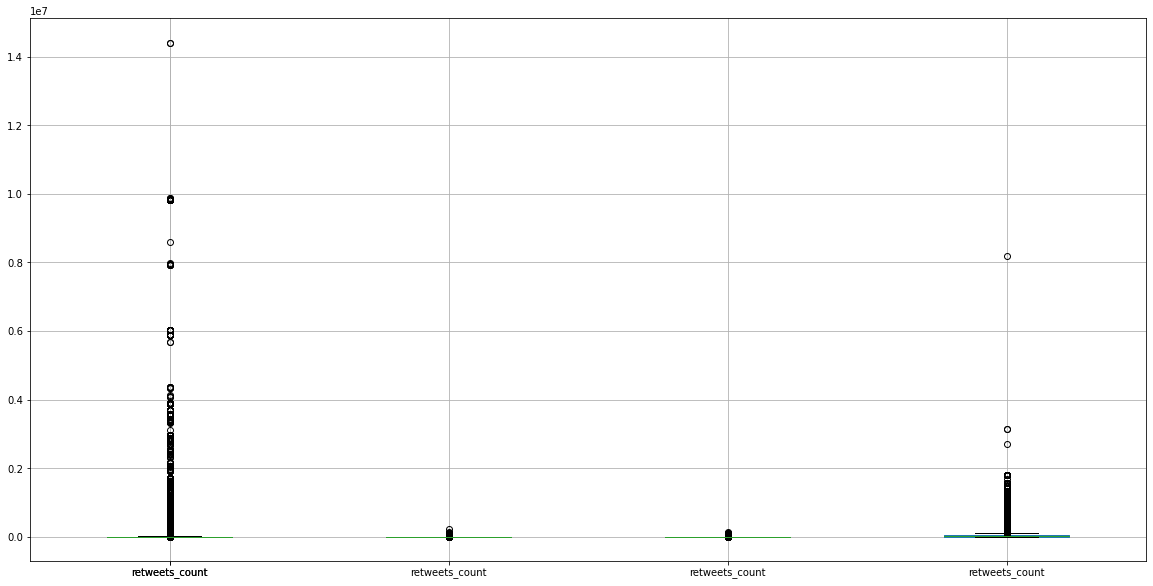

In [21]:
#show outliers
plt.rcParams['figure.figsize'] = [20, 10]
train_data.boxplot(column=['followers_count', 'friends_count', 'favorites_count', 'statuses_count'])
#increase size
plt.rcParams['figure.figsize'] = [20, 10]
train_data.boxplot(column=[ 'retweets_count'])
plt.show()

# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 3 * iqr) & (df[col] <= q3 + 3 * iqr)]
    return df

train_data = remove_outliers(train_data, 'followers_count')
train_data = remove_outliers(train_data, 'friends_count')
train_data = remove_outliers(train_data, 'favorites_count')
train_data = remove_outliers(train_data, 'statuses_count')
train_data = remove_outliers(train_data, 'retweets_count')
#reset index
train_data = train_data.reset_index(drop=True)


# see 1-s2.0-S1877050920304129-main.pdf p3

# Splitting

In [22]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)


# Data cleaning

In [23]:
#mentions is always empty -> DROP Mention

X_train = X_train.drop(['mentions'], axis=1)
X_test = X_test.drop(['mentions'], axis=1)

#Tweet id is not relevant -> DROP Tweet id
X_train = X_train.drop(['TweetID'], axis=1)
X_test = X_test.drop(['TweetID'], axis=1)


# New Features

In [24]:
#add a column to data which counts url
X_train['url_count'] = X_train['urls'].str.count('http')
X_test['url_count'] = X_test['urls'].str.count('http')
X_train = X_train.drop(['urls'], axis=1)
X_test = X_test.drop(['urls'], axis=1)

# add a column to data which counts the number of hashtags
X_train['hashtag_count'] = X_train['hashtags'].str.count('#')
X_test['hashtag_count'] = X_test['hashtags'].str.count('#')
X_train = X_train.drop(['hashtags'], axis=1)
X_test = X_test.drop(['hashtags'], axis=1)

#add a column to data which makes followers/friends
X_train['followers_friends'] = X_train['followers_count'] / X_train['friends_count']
X_test['followers_friends'] = X_test['followers_count'] / X_test['friends_count']

#add a column
#number of characters in the tweet
X_train_length = X_train['text'].apply(lambda x: len(x))
X_test_length = X_test['text'].apply(lambda x: len(x))
#x_train_doc to df
X_train_length = pd.DataFrame(X_train_length.values.tolist())
X_test_length = pd.DataFrame(X_test_length.values.tolist())
#drop the text column
X_train = X_train.drop(['text'], axis=1)
X_test = X_test.drop(['text'], axis=1)


# Features selection

### Pipeline example

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
 


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -10.538812 (0.886428)
ScaledLASSO: -10.124824 (0.953406)
ScaledEN: -13.899756 (1.088446)
ScaledKNN: -7.218124 (0.799233)
ScaledCART: -8.597397 (0.835062)
ScaledGBM: -6.802502 (0.651244)
ScaledRF: -6.391916 (0.703740)
ScaledMLP: -8.864348 (0.715103)


After 55min: StandardScaler, no extraction, no selection, add feat =url count
- ScaledLR: -10.538812 (0.886428)
- ScaledLASSO: -10.124824 (0.953406)
- ScaledEN: -13.899756 (1.088446)
- ScaledKNN: -7.218124 (0.799233)
- ScaledCART: -8.597397 (0.835062)
- ScaledGBM: -6.802502 (0.651244)
- ScaledRF: -6.391916 (0.703740)
- ScaledMLP: -8.864348 (0.715103)

 No extraction nor selection, MinMaxScaler, add feat =url count

- ScaledLR: -10.433137 (0.871373)
- ScaledLASSO: -20.037637 (1.619121)
- ScaledEN: -26.620310 (1.340733)
- ScaledKNN: -7.534165 (0.766204)
- ScaledCART: -8.391123 (0.749394)
- ScaledGBM: -6.639914 (0.724651)
- ScaledRF: -6.230696 (0.714884)
- ScaledMLP: -8.770942 (0.776259)




Bilan: Min MaxScaler is better


### Importance of features with RFE for each algo

In [ ]:
#To DO

# Feature selection

Covariance matrix

In [ ]:
# plot data covariance matrix for train with features labels
cov=X_train.corr()


from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(cov),no_plot=False)['ivl'], dtype="int")

rearranged_cov = cov.iloc[order, order]
plt.matshow(rearranged_cov)
plt.xticks(range(len(X_train.columns)), X_train.columns[order], rotation=90)
plt.yticks(range(len(X_train.columns)), X_train.columns[order])
plt.colorbar()
plt.show()





NameError: name 'X_train' is not defined

Correlation with target

In [ ]:
#concatenate X_train and y_train
X_train.corrwith(y_train).plot.bar(
        #show exact values
        figsize = (20, 10), title = "Correlation with retweets_count", fontsize = 15,
        rot = 90, grid = True)

plt.show()

print(X_train.corrwith(y_train))



Gini

In [ ]:
#Gini information-> TO DO

# Pipeline with selected features 

In [ ]:
#Test different models for each set of features selected by the gini information/feature importance

# Pipeline with extracted features